## Cardiovascular study

I will be working on a cardiovascular study dataset, focusing on building a logistic regression model to predict the 10-year risk of coronary heart disease (CHD). 
The dataset includes several features like age, education, smoking habits, cholesterol levels, blood pressure, BMI, and more.

In [2187]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve
from sklearn.metrics import roc_curve, auc
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [2189]:
df = pd.read_csv("D:/Studies/Predictive models/train.csv")
df.shape

(3390, 17)

For this task, columns that might not be relevant for predicting the 10-year risk of coronary heart disease would typically be those that do not directly contribute to the health-related features or outcomes. Which could that be?

Here are my insights regarding unuseful data for this project:
* Education: This could be useful depending on the context, but in many health-related studies, it's often removed if it doesn't have a clear connection to the outcome.
* ID: This is just an identifier and doesn't provide any useful information for prediction, but I would leave it as it can be useful for ensuring that data points are not duplicated or missing.

In [2193]:
remove_columns = [
    "education"
]

In [2195]:
df = df.drop(columns=remove_columns)

Let’s examine a sample of the data to see if anything appears unusual.

In [2197]:
df.sample(10)

,id,age,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
1666,1666,38,F,YES,15.0,0.0,0,0,0,215.0,129.5,85.5,24.24,75.0,NaN,0
2609,2609,53,M,YES,30.0,1.0,0,1,0,190.0,141.0,115.0,21.01,115.0,86.0,1
3044,3044,63,M,YES,43.0,0.0,0,1,0,253.0,172.0,82.0,24.19,66.0,137.0,1
720,720,61,F,NO,0.0,0.0,0,1,0,300.0,150.5,89.0,NaN,68.0,72.0,1
308,308,48,F,NO,0.0,0.0,0,1,0,211.0,149.0,100.0,30.91,78.0,62.0,0
70,70,50,M,YES,30.0,0.0,0,0,0,210.0,121.5,78.0,26.29,88.0,77.0,0
1293,1293,53,M,NO,0.0,0.0,0,0,0,225.0,108.5,73.0,26.55,54.0,73.0,0
1832,1832,36,M,NO,0.0,0.0,0,1,0,167.0,155.0,74.0,19.42,125.0,81.0,0
761,761,53,F,NO,0.0,0.0,0,0,0,185.0,96.0,72.0,21.35,60.0,82.0,0
1285,1285,55,M,NO,0.0,0.0,0,0,0,298.0,169.5,104.5,27.51,76.0,78.0,0


* In this dataset, we have a NaN value in the glucose column for the row with id 1552.
* The is_smoking column has "YES" and "NO" values, which are categorical. It's important to ensure they are correctly encoded, typically using one-hot encoding or label encoding, before fitting a model.
* The cigsPerDay column has values like 0.0 and 30.0. While some people may not smoke (0), others smoke at a much higher rate, which could lead to a skewed distribution.

In [2201]:
df = df.dropna(subset=["glucose"])
df.shape

(3086, 16)

Hidden issue from the sample data are the potential NaNs in other columns. Let’s investigate it.

In [2204]:
df.isna().mean()

id                 0.000000
age                0.000000
sex                0.000000
is_smoking         0.000000
cigsPerDay         0.006157
BPMeds             0.013610
prevalentStroke    0.000000
prevalentHyp       0.000000
diabetes           0.000000
totChol            0.002916
sysBP              0.000000
diaBP              0.000000
BMI                0.003564
heartRate          0.000324
glucose            0.000000
TenYearCHD         0.000000
dtype: float64

Given that the missing values are relatively low across these columns, it's unlikely to significantly impact the overall model performance if handled correctly. I will fill the missing values with the mean or median for continuous variables like cigsPerDay, BMI, and totChol.

In [2207]:
df['cigsPerDay'] = df['cigsPerDay'].fillna(df['cigsPerDay'].median())
df['BPMeds'] = df['BPMeds'].fillna(df['BPMeds'].mode()[0])
df['totChol'] = df['totChol'].fillna(df['totChol'].median())
df['BMI'] = df['BMI'].fillna(df['BMI'].median())
df['heartRate'] = df['heartRate'].fillna(df['heartRate'].median())

Lets inspect the dataset to see if there are any more issues.

In [2210]:
df.describe().round(2)

,id,age,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,3086.00,3086.00,3086.00,3086.00,3086.00,3086.00,3086.00,3086.00,3086.00,3086.00,3086.00,3086.00,3086.00,3086.00
mean,1690.42,49.61,9.00,0.03,0.01,0.32,0.03,237.25,132.74,82.94,25.82,75.82,82.09,0.15
std,983.44,8.63,11.87,0.17,0.08,0.47,0.16,45.37,22.37,12.07,4.11,11.89,24.24,0.36
min,0.00,32.00,0.00,0.00,0.00,0.00,0.00,107.00,83.50,48.00,15.96,45.00,40.00,0.00
25%,836.25,42.00,0.00,0.00,0.00,0.00,0.00,206.00,117.00,74.50,23.06,68.00,71.00,0.00
50%,1687.50,49.00,0.00,0.00,0.00,0.00,0.00,234.00,129.00,82.00,25.40,75.00,78.00,0.00
75%,2541.75,57.00,20.00,0.00,0.00,1.00,0.00,264.00,144.00,90.00,28.06,83.00,87.00,0.00
max,3389.00,70.00,70.00,1.00,1.00,1.00,1.00,696.00,295.00,142.50,56.80,143.00,394.00,1.00


Some insights which could be detected during inspection of our dataset.

* totChol (total cholesterol): The minimum value is 107.0, which seems quite low for total cholesterol levels, especially since most healthy adults have levels above 150.
* The maximum value for cigsPerDay is 70.0, which seems unusually high. But I will keep this value, as a lot of nicotine addicted people can indeed smoke between 4-5 packages of cigarettes per day.
* The maximum value for sysBP is 295.0, which is extremely high. For a typical adult, systolic blood pressure values above 180-200 are considered dangerously high.
* The maximum value for glucose is 394.0, which is quite high.

In [2213]:
df[df['sysBP'] > 200]
df[df['glucose'] > 300]
df[df['glucose'] > 150]

,id,age,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
77,77,63,F,NO,0.0,0.0,0,1,1,150.0,152.0,88.0,36.54,72.0,170.0,0
107,107,45,M,NO,0.0,0.0,0,0,1,189.0,132.0,78.0,28.40,75.0,177.0,0
134,134,64,F,NO,0.0,0.0,0,1,1,262.0,147.0,90.0,26.51,85.0,173.0,0
151,151,52,M,YES,20.0,0.0,0,0,0,265.0,106.0,79.0,26.48,80.0,163.0,1
173,173,58,F,NO,0.0,0.0,1,1,1,267.0,157.0,94.0,33.32,92.0,205.0,1
230,230,52,M,YES,20.0,0.0,0,0,1,258.0,132.0,80.0,27.52,90.0,268.0,1
312,312,46,F,YES,15.0,0.0,0,0,1,233.0,106.0,60.0,20.84,75.0,348.0,0
400,400,58,F,NO,0.0,0.0,0,1,1,240.0,150.0,80.0,26.45,66.0,255.0,1
481,481,55,F,YES,20.0,0.0,0,0,1,216.0,125.0,80.0,27.18,86.0,244.0,0
534,534,54,F,NO,0.0,0.0,0,0,1,223.0,110.0,67.5,21.22,78.0,294.0,0


Now let's inspect the categorical variables.

In [2216]:
df["sex"].value_counts()

sex
F    1710
M    1376
Name: count, dtype: int64

In [2218]:
df["is_smoking"].value_counts()

is_smoking
NO     1557
YES    1529
Name: count, dtype: int64

Both "sex" and "is_smoking" values look great - there are only 2 genders, as supposed to be, and only 2 options for being a smoker or not.

I will convert these two categorical variables (gender and is_smoking) to numeric, since it will make easier modelling.

In [2222]:
df["sex"] = df["sex"].map({"F": 0, "M": 1})
df["is_smoking"] = df["is_smoking"].map({"NO": 0, "YES": 1})

In [2224]:
df.sample(10)

,id,age,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
2853,2853,43,0,1,5.0,0.0,0,0,0,214.0,121.0,84.0,24.68,80.0,74.0,0
621,621,50,0,0,0.0,0.0,0,0,0,305.0,114.0,80.0,24.33,55.0,80.0,0
2465,2465,61,1,1,13.0,0.0,0,0,0,312.0,110.0,66.0,26.28,68.0,96.0,0
830,830,55,0,1,9.0,0.0,0,1,0,263.0,155.0,84.0,27.87,68.0,60.0,0
1923,1923,60,0,1,3.0,0.0,0,0,0,314.0,141.0,93.0,25.23,105.0,94.0,0
2339,2339,43,1,1,20.0,0.0,0,0,0,202.0,104.0,69.0,25.82,59.0,63.0,0
525,525,39,1,0,0.0,0.0,0,0,0,203.0,117.5,77.5,27.29,88.0,60.0,0
2413,2413,46,0,1,20.0,0.0,0,0,0,250.0,112.5,60.0,22.72,82.0,74.0,0
960,960,59,1,1,20.0,0.0,0,0,0,206.0,115.0,70.0,24.79,84.0,76.0,0
2105,2105,36,1,1,20.0,0.0,0,0,0,203.0,101.5,67.0,24.43,65.0,74.0,0


We can move on with EDA.

## *Exploratory Data Analysis*


The target variable for prediction is TenYearCHD, which indicates whether a person has coronary heart disease (1 = CHD, 0 = no CHD).

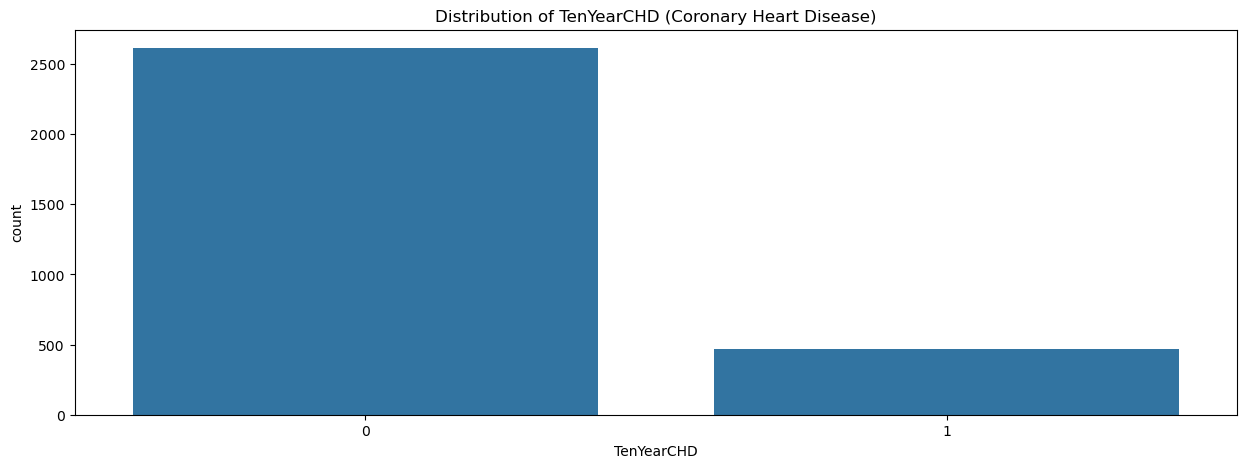

In [2229]:
sns.countplot(x='TenYearCHD', data=df)
plt.title('Distribution of TenYearCHD (Coronary Heart Disease)')
plt.show()

Our data is imbalanced, which is correct, since not having CHD is less common than having it.

Let’s investigate which variables are most strongly correlated with TenYearCHD. For categorical and count variables, I’ll use boxplots to visualize the relationship. For continuous variables, I’ll use scatterplots to assess the correlation more clearly.

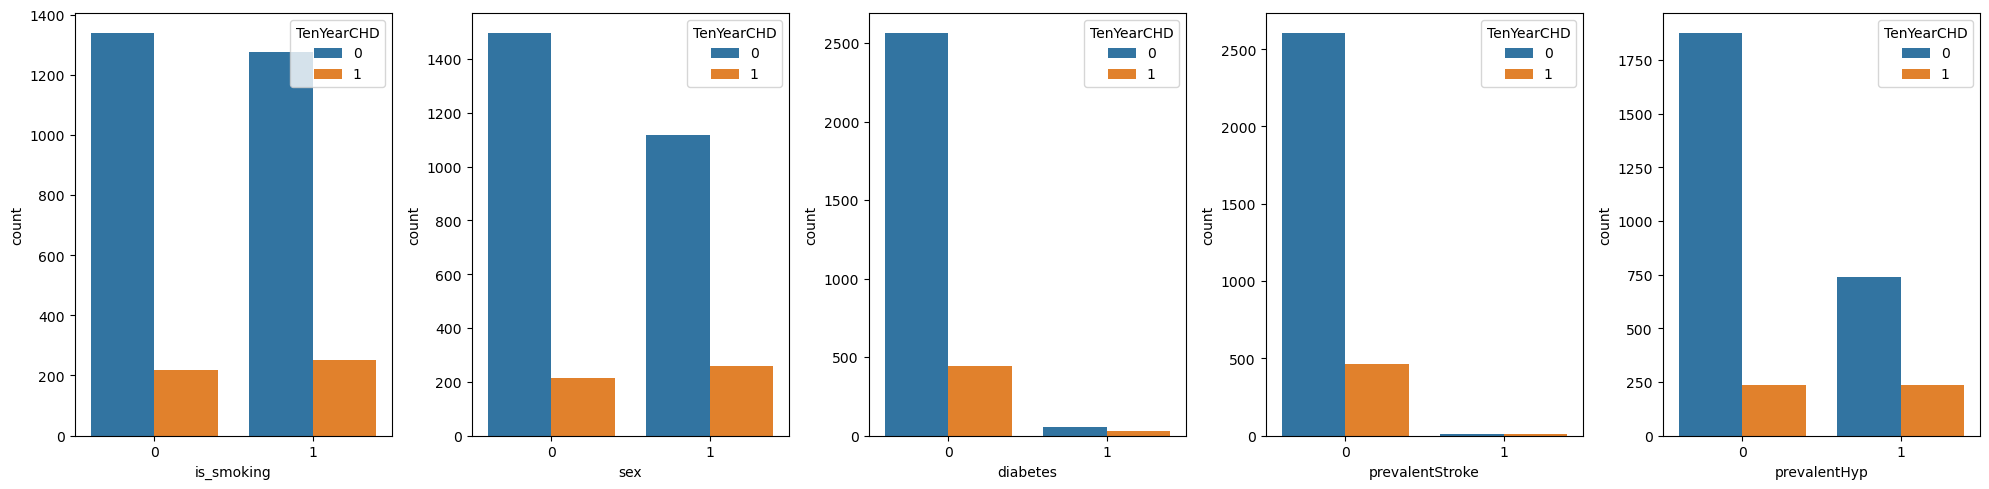

In [2233]:
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

sns.countplot(x="is_smoking", hue="TenYearCHD", data=df, ax=axs[0])
sns.countplot(x="sex", hue="TenYearCHD", data=df, ax=axs[1])
sns.countplot(x="diabetes", hue="TenYearCHD", data=df, ax=axs[2])
sns.countplot(x="prevalentStroke", hue="TenYearCHD", data=df, ax=axs[3])
sns.countplot(x="prevalentHyp", hue="TenYearCHD", data=df, ax=axs[4])

plt.tight_layout()
plt.show()

* Non-Smokers have higher count of individuals with no heart disease than those who smoke.
* Smokers have higher count of individuals with heart disease.
* Smoking appears to have a less significant role in causing heart disease in this dataset.

* Females have higher count of individuals with no heart disease than those who smoke.
* Males have higher count of individuals with heart disease.

* People without diabetes are indicating a much lower risk of heart disease. People with diabetes have a significantly higher count of heart disease, suggesting that diabetes is a strong risk factor for heart disease.

* A graph of stroke appears to be a significant risk factor for heart disease, as most individuals with a prior stroke seem to also have heart disease.

* Hypertension is another risk factor for heart disease, though not as strongly as diabetes or a previous stroke.


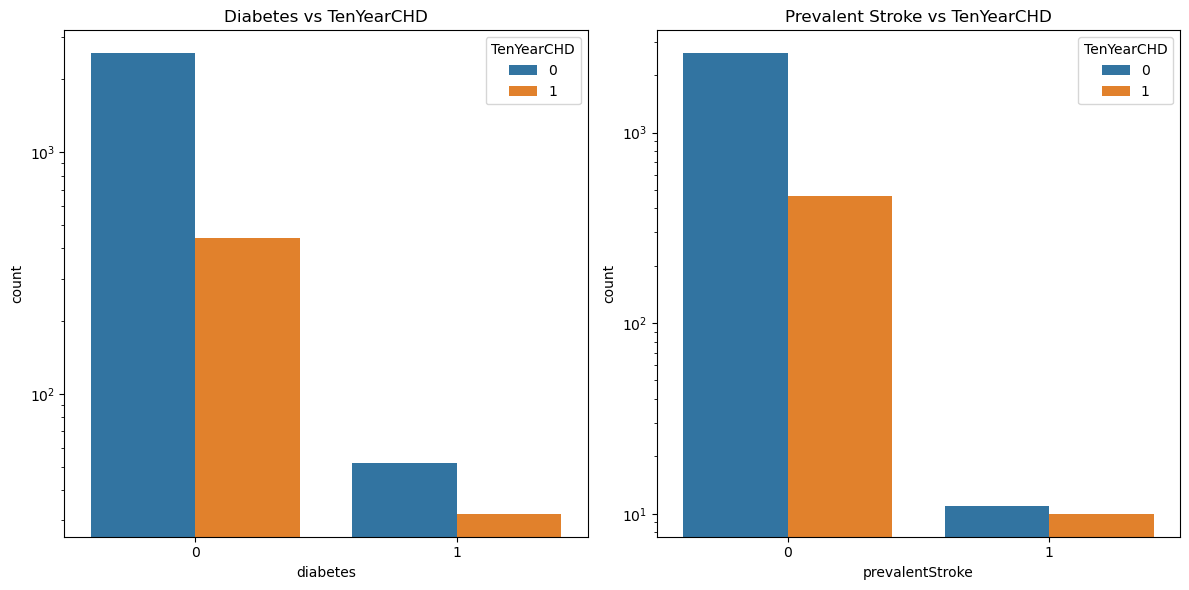

In [2235]:
df['prevalentStroke'] = df['prevalentStroke'].astype('category')
df['prevalentHyp'] = df['prevalentHyp'].astype('category')

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

sns.countplot(x="diabetes", hue="TenYearCHD", data=df, ax=axs[0])
sns.countplot(x="prevalentStroke", hue="TenYearCHD", data=df, ax=axs[1])

axs[0].set_yscale('log') 
axs[1].set_yscale('log') 

axs[0].set_title('Diabetes vs TenYearCHD')
axs[1].set_title('Prevalent Stroke vs TenYearCHD')

plt.tight_layout()
plt.show()

In [2236]:
correlations = df[['age', 'cigsPerDay', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose', 'TenYearCHD']].corr()
print(correlations['TenYearCHD'])

age           0.234469
cigsPerDay    0.065450
sysBP         0.218780
diaBP         0.137333
BMI           0.073896
heartRate     0.018845
glucose       0.138200
TenYearCHD    1.000000
Name: TenYearCHD, dtype: float64


                  id       age       sex  is_smoking  cigsPerDay    BPMeds  \
id          1.000000  0.020226 -0.005204   -0.010906   -0.029577  0.011770   
age         0.020226  1.000000 -0.037744   -0.210540   -0.190406  0.131327   
sex        -0.005204 -0.037744  1.000000    0.221977    0.338588 -0.040754   
is_smoking -0.010906 -0.210540  0.221977    1.000000    0.765823 -0.042477   
cigsPerDay -0.029577 -0.190406  0.338588    0.765823    1.000000 -0.035731   
BPMeds      0.011770  0.131327 -0.040754   -0.042477   -0.035731  1.000000   
diabetes    0.007191  0.114431  0.006193   -0.058226   -0.052418  0.076786   
totChol    -0.019936  0.272237 -0.072025   -0.047541   -0.028617  0.091123   
sysBP       0.026954  0.406835 -0.047969   -0.152945   -0.107164  0.272971   
diaBP       0.004449  0.226730  0.054359   -0.132160   -0.070783  0.202492   
BMI         0.039814  0.139629  0.078218   -0.167364   -0.099938  0.088918   
heartRate   0.028070  0.007541 -0.119211    0.059077    0.062123

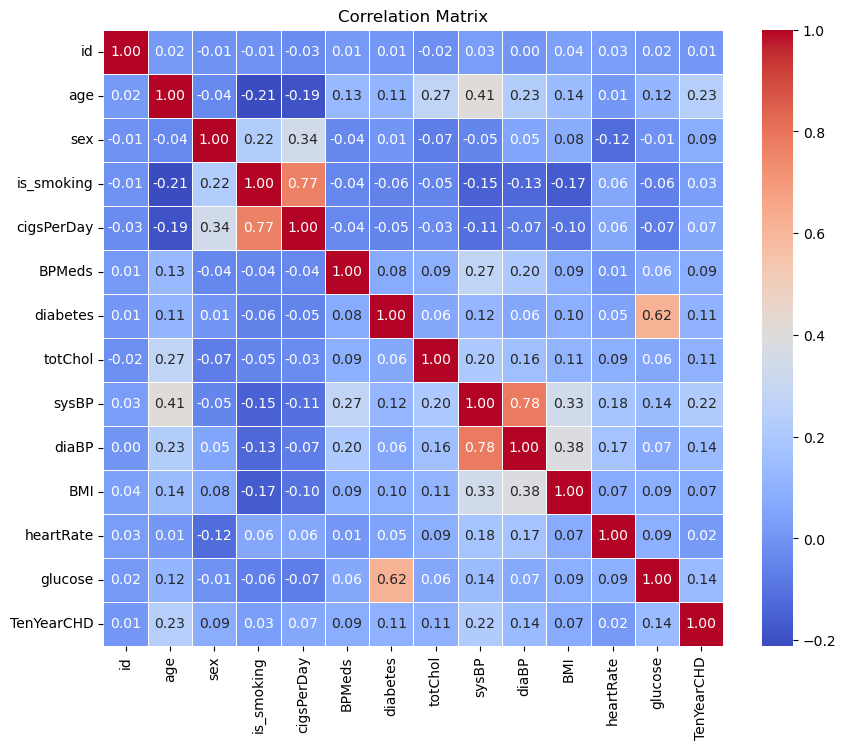

In [2238]:
corr_matrix = df.select_dtypes(include=['float64', 'int64']).corr()

print(corr_matrix)

plt.figure(figsize=(10, 8)) 
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

*Key Findings*

Age shows a moderate positive correlation with systolic blood pressure (sysBP, 0.40) and total cholesterol (totChol, 0.27), suggesting that these risk factors tend to increase with age.
Prevalent hypertension (prevalentHyp) shows a strong correlation with both systolic blood pressure (0.70) and diastolic blood pressure (0.61), which makes complete sense from perspective of medical condition.
Diabetes demonstrates a strong correlation with glucose levels (0.62).
Cigarettes per day (cigsPerDay) has a weak positive correlation with Ten-Year CHD risk (0.07), indicating a small potential impact in this dataset.
Ten-Year CHD risk is most strongly correlated with systolic blood pressure (0.21) and age (0.22), which we also noticed before, highlighting them as significant cardiovascular risk factors.

*Multicollinearity Insights* 

Based on the correlation matrix, several features are highly correlated and may cause multicollinearity issues in logistic regression:

Prevalent hypertension and systolic blood pressure: Correlation of 0.699.
Diastolic blood pressure and systolic blood pressure: Correlation of 0.782.

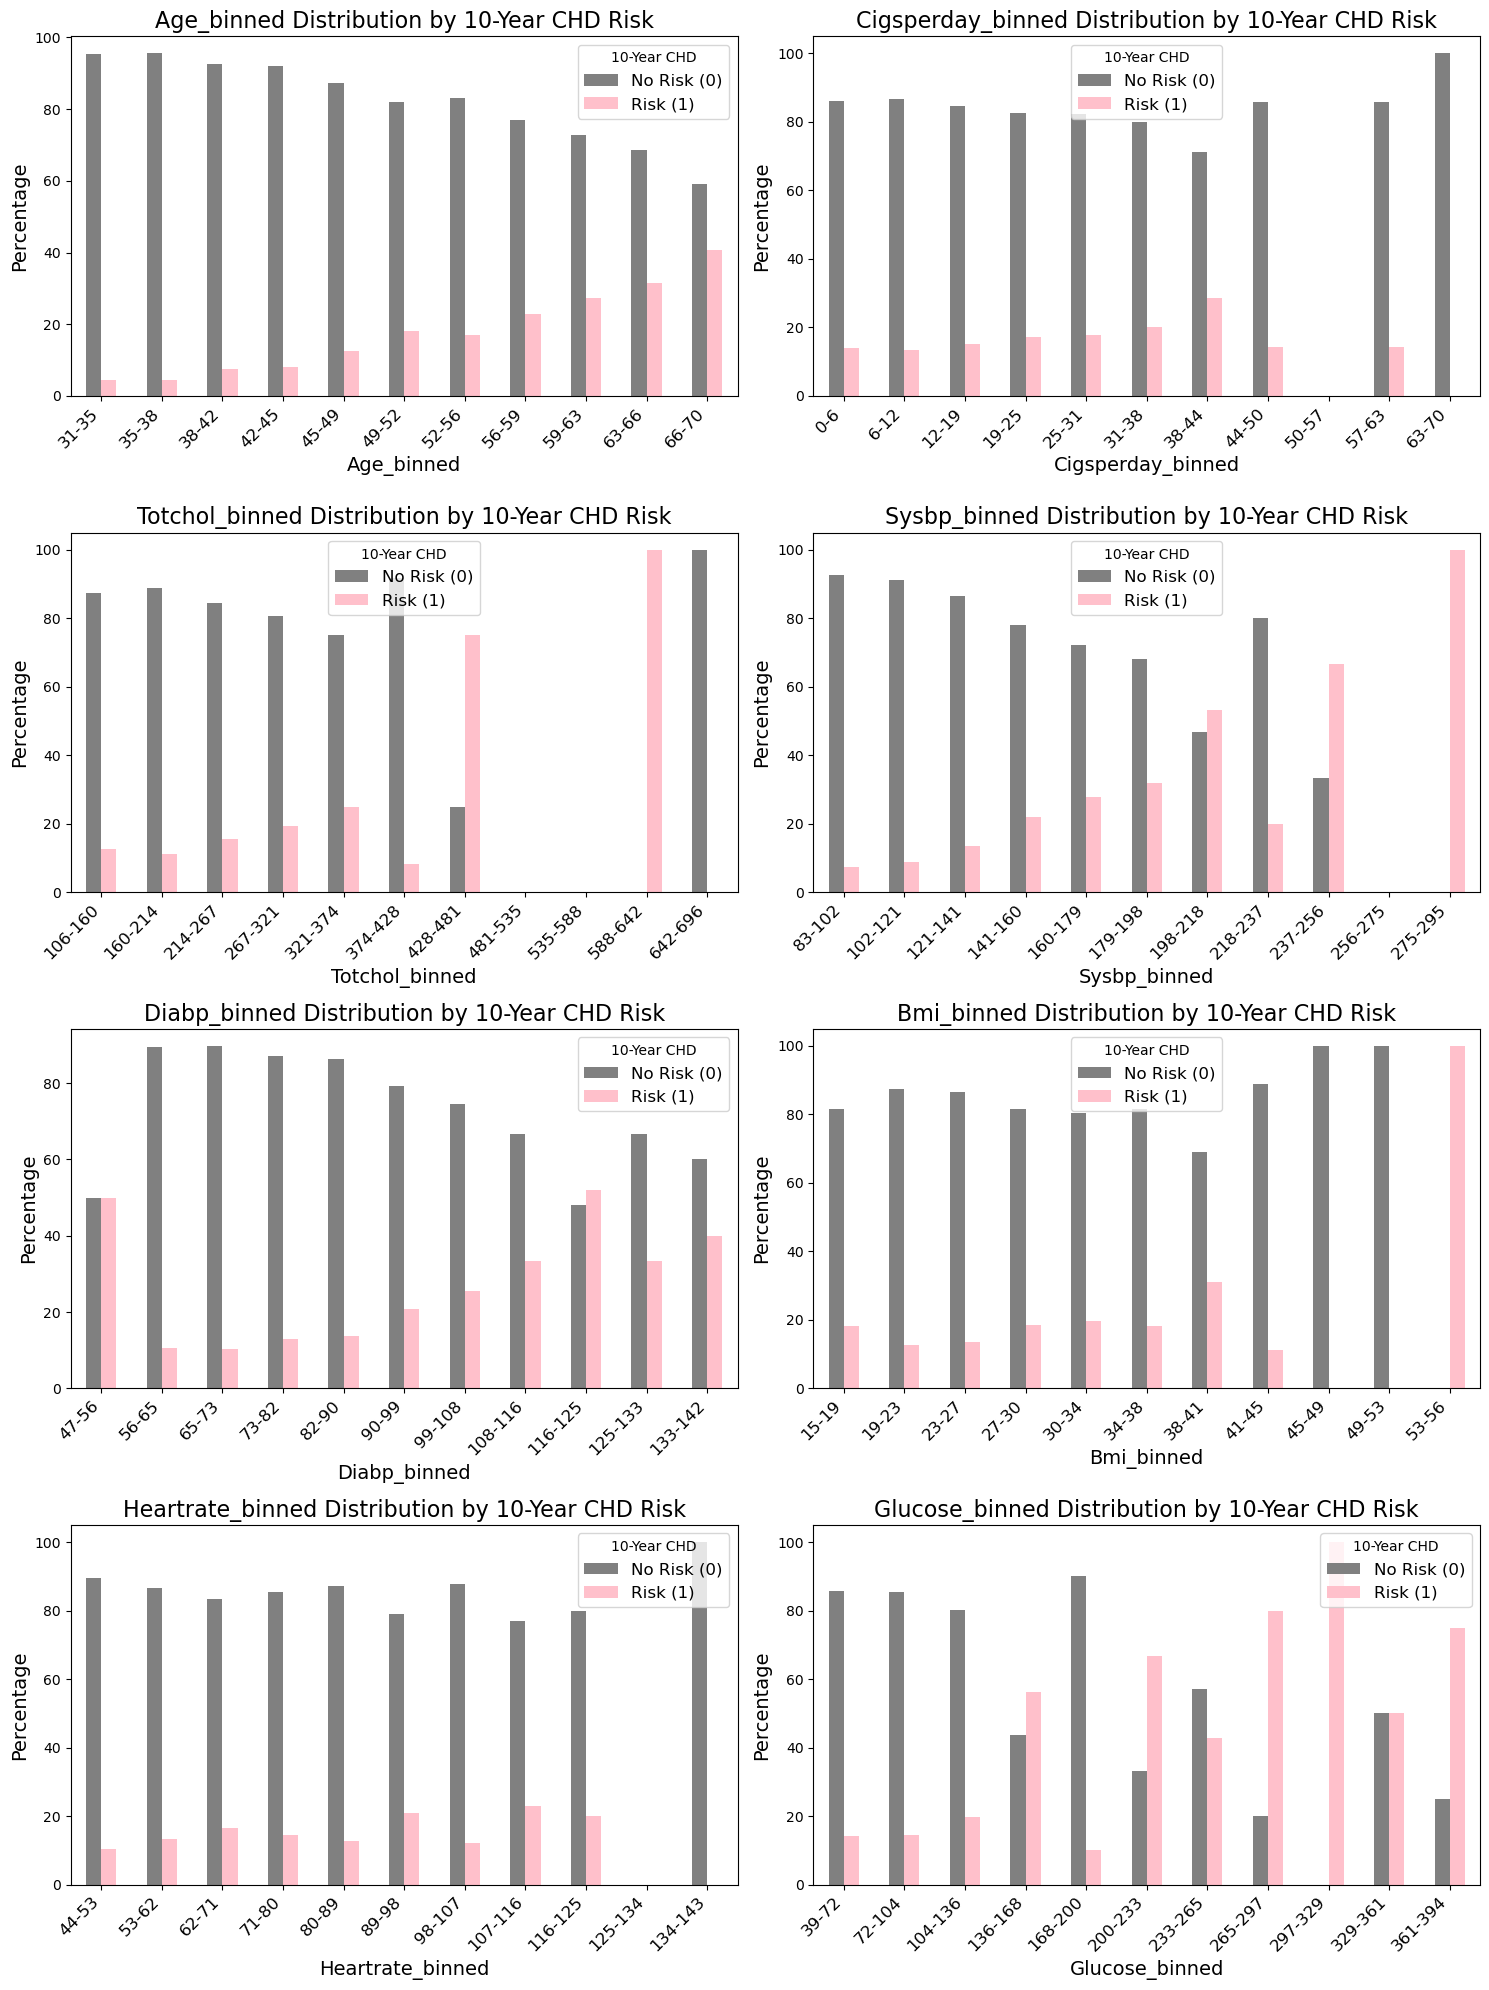

In [2240]:
continuous_features = ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']

custom_palette = {0: 'gray', 1: 'pink'}
num_bins = 11

def format_binned_labels(xticklabels):
    return [f"{int(interval.left)}-{int(interval.right)}" if hasattr(interval, 'left') else interval 
            for interval in xticklabels]

def plot_feature(ax, feature, binned_data):
    risk_percentage = binned_data.groupby([feature, 'TenYearCHD'], observed=False).size().unstack(fill_value=0)
    risk_percentage = risk_percentage.apply(lambda x: 100 * x / x.sum(), axis=1)
    
    bars = risk_percentage.plot(kind='bar', stacked=False, color=[custom_palette[0], custom_palette[1]], ax=ax)
    
    ax.set_title(f'{feature.capitalize()} Distribution by 10-Year CHD Risk', fontsize=16)
    ax.set_xlabel(feature.capitalize(), fontsize=14)
    ax.set_ylabel('Percentage', fontsize=14)
    ax.set_xticklabels(format_binned_labels(risk_percentage.index), rotation=45, ha='right', fontsize=12)
    
    for p in bars.patches:
        if p.get_facecolor() == custom_palette[1] and p.get_height() > 0:  # Only risk bars (pink) with nonzero height
            x_pos = p.get_x() + p.get_width() / 2  # Center of bar
            y_pos = p.get_height() + 1  # Slightly above bar
            ax.text(x_pos, y_pos, f'{round(p.get_height(), 1)}%', ha='center', fontsize=12)
    
    ax.legend(title='10-Year CHD', labels=['No Risk (0)', 'Risk (1)'], fontsize=12)

n_cols = 2
n_rows = (len(continuous_features) + n_cols - 1) // n_cols  # Dynamically calculate the number of rows needed
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten()

for i, feature in enumerate(continuous_features):
    # Create a new binned column for each feature, preserving original data
    df[f'{feature}_binned'] = pd.cut(df[feature], bins=num_bins)
    plot_feature(axes[i], f'{feature}_binned', df)

for k in range(len(continuous_features), len(axes)):
    fig.delaxes(axes[k])

plt.tight_layout()
plt.show()


* Age vs. CHD Risk: The risk of 10-year CHD (pink bars) increases as age increases, especially after 56 years.
* Cigarettes Per Day vs. CHD Risk: Higher smoking levels (above 25 cigarettes per day) show a higher proportion of CHD risk.
* Total Cholesterol vs. CHD Risk: CHD risk is more noticeable in higher cholesterol levels (above 428 mg/dL).
* Systolic Blood Pressure vs. CHD Risk: CHD risk is low at normal blood pressure levels but increases significantly after 198 mmHg.
* Diastolic Blood Pressure vs. CHD Risk: CHD risk increases as diastolic blood pressure exceeds 116 mmHg.
* BMI vs. CHD Risk: Higher BMI values (above 49) show a significant increase in CHD risk.
* Heart Rate vs. CHD Risk: No clear trend, but higher heart rates (above 125 bpm) show slightly higher CHD risk.
* Glucose vs. CHD Risk: CHD risk remains low at normal glucose levels but spikes significantly above 265 mg/dL.

Let's look at distribution of our data.

Skewness of totChol data: 0.9741364529330007
Skewness of sysBP data: 1.1920743609556945
Skewness of diaBP data: 0.7123606995242594
Skewness of BMI data: 1.040857740024678
Skewness of heartRate data: 0.6965262275121918
Skewness of glucose data: 6.1443896544049394


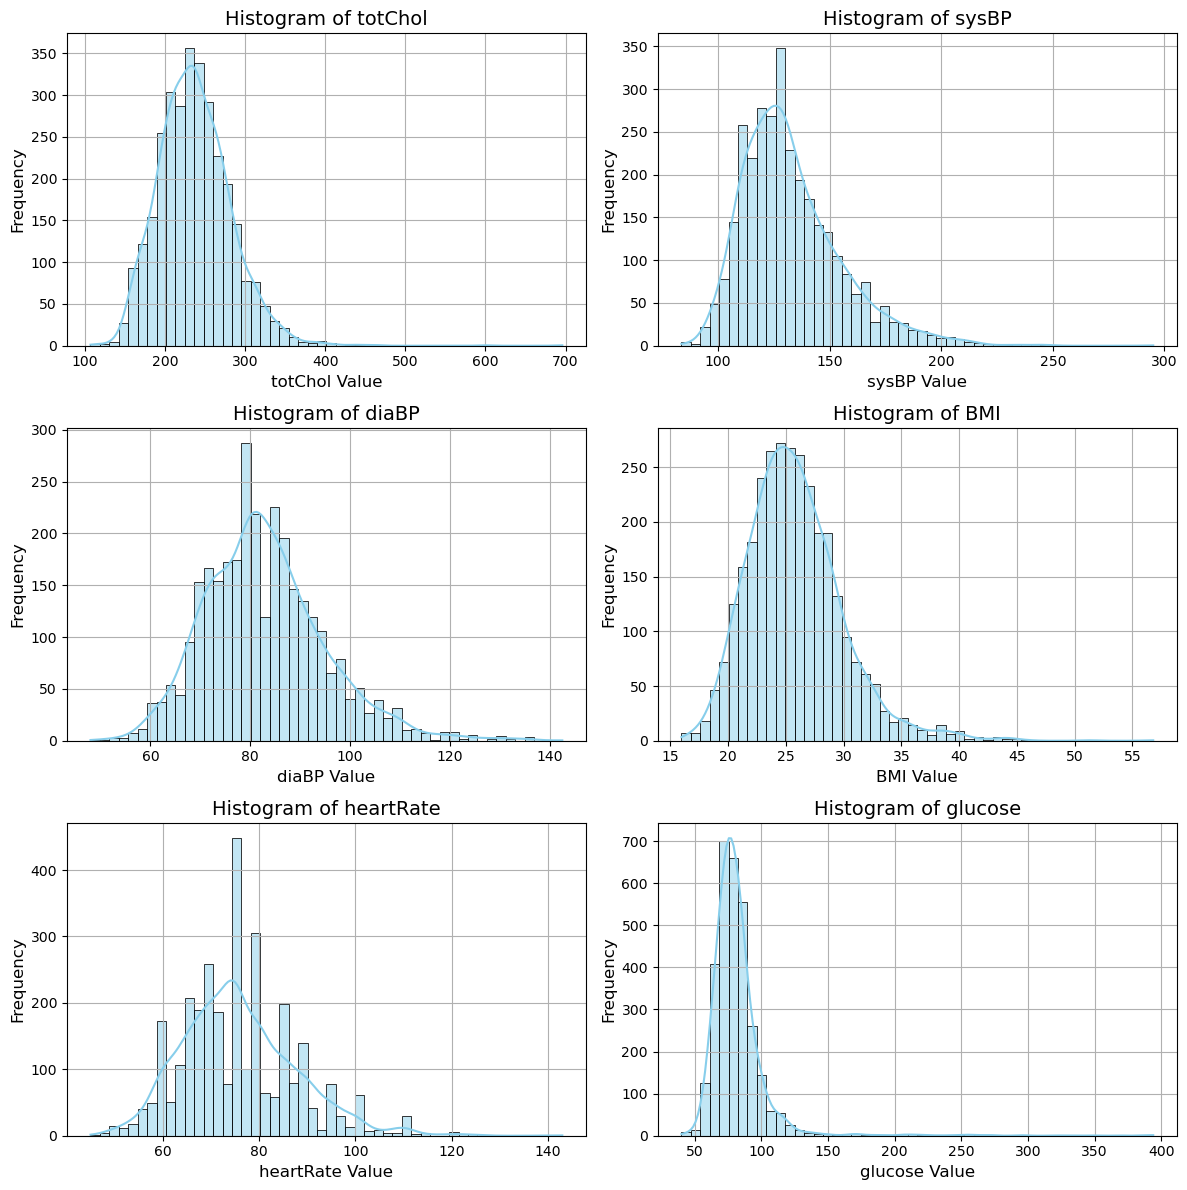

In [2245]:
features = ['totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']

plt.figure(figsize=(12, 12))

for i, feature in enumerate(features, start=1):
    plt.subplot(3, 2, i)  # Create subplots (3 rows, 2 columns)
    sns.histplot(df[feature], bins=50, kde=True, color='skyblue', edgecolor='black')
    
    plt.title(f'Histogram of {feature}', fontsize=14)
    plt.xlabel(f'{feature} Value', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True)

    skewness = df[feature].skew()
    print(f'Skewness of {feature} data: {skewness}')

plt.tight_layout()
plt.show()

Highly skewed variables should be log transformed to normalize their distributions.
Highly skewed features:
sysBP (1.19)
BMI (1.04)
glucose (6.14)

Highly skewed features:
sysBP (1.19)
BMI (1.04)
glucose (6.14)

In [2249]:
log_vars = ['BMI', 'sysBP', 'glucose']

df[log_vars] = df[log_vars].apply(lambda x: np.log1p(x))


## Logistic regression model

I define features (X) and target variable (Y) by separating the predictors (X) from the outcome (Y). Ten Year CHD is our variable.

Why these features?
* Age – Older individuals are at higher risk of CHD. 
* CigsPerDay – Smoking is a known risk factor for CHD. 
* TotChol (Total Cholesterol) – High cholesterol is linked to heart disease. 
* SysBP (Systolic Blood Pressure) – High blood pressure increases heart disease risk. 
* BMI (Body Mass Index) – Obesity contributes to heart disease. 
* HeartRate – Elevated heart rate can indicate cardiovascular issues. 
* Glucose – High blood sugar is linked to diabetes, which is a CHD risk factor. 
* DiaBP (Diastolic Blood Pressure) – Like SysBP, it contributes to overall blood pressure.
* Diabetes – A direct indicator of metabolic health.
* PrevalentHyp (Hypertension) – High blood pressure history could add value.

What we don't include:
* Including BPMeds might create bias, as it reflects medical intervention rather than natural risk factors.
* PrevalentStroke, as it could introduce collinearity with other strong risk factors like high blood pressure (sysBP, diaBP), meaning it doesn’t add much new information.
* Heart rate, as proportion of individuals at risk appears relatively consistent across different heart rate ranges, and correlation is really low.

In [2253]:
X = df[['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'glucose', 'diabetes', 'prevalentHyp']]
y = df['TenYearCHD']

In [2254]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [2255]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [2256]:
model = LogisticRegression(max_iter=1000)

model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000)

Logistic Regression uses a decision threshold of 0.5 by default. 
However, this may not be the best threshold in the case of an imbalanced dataset, which is ours in this case. 
To find the optimal threshold, we can compute precision, recall, and F1-score at different thresholds.

In [2259]:
y_probs = model.predict_proba(X_test_scaled)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

f1_scores = (2 * precisions * recalls) / (precisions + recalls)
best_threshold = thresholds[f1_scores.argmax()]

print(f"Optimal Threshold: {best_threshold}")

Optimal Threshold: 0.22783166273197822


In [2269]:
y_pred = (y_probs >= best_threshold).astype(int)

Accuracy: 0.7686
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.83      0.86       523
           1       0.32      0.44      0.37        95

    accuracy                           0.77       618
   macro avg       0.60      0.64      0.61       618
weighted avg       0.80      0.77      0.78       618

Confusion Matrix:
 [[433  90]
 [ 53  42]]


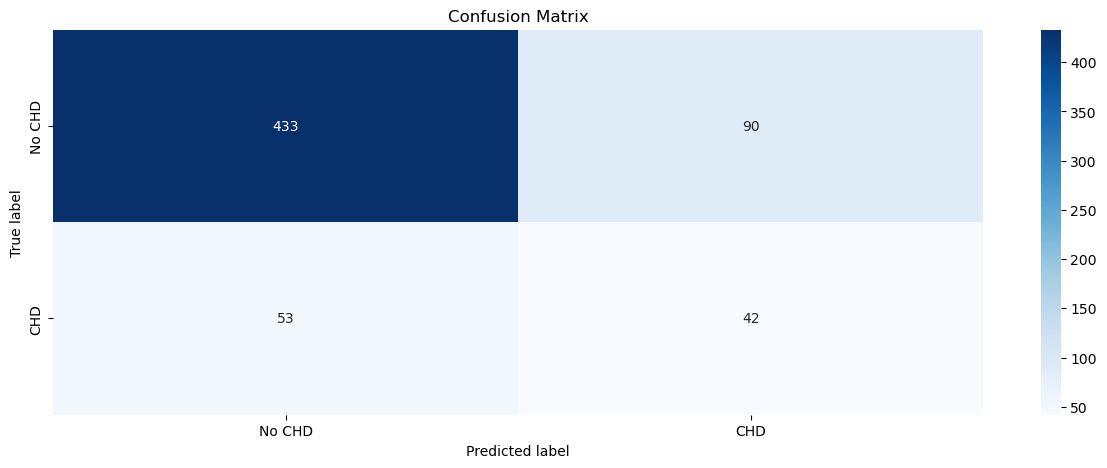

Predicted class distribution: (array([0, 1]), array([486, 132], dtype=int64))


In [2271]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))  # Avoid undefined metrics

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No CHD', 'CHD'], yticklabels=['No CHD', 'CHD'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

# Check class distribution in predictions
y_pred_counts = np.unique(y_pred, return_counts=True)
print("Predicted class distribution:", y_pred_counts)

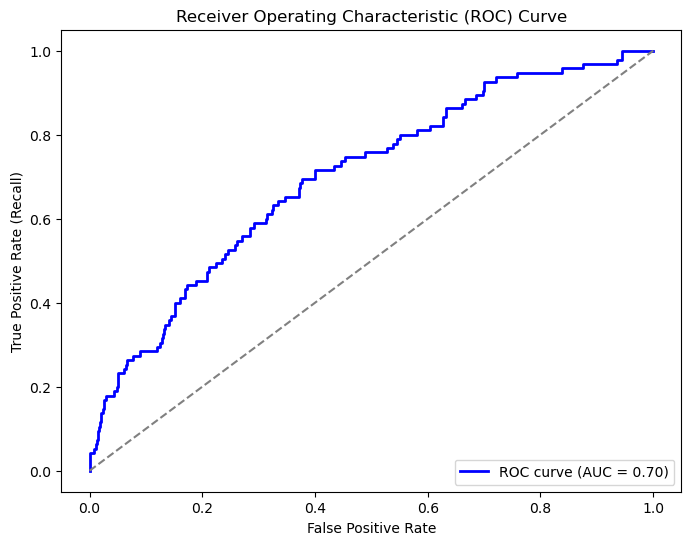

Area Under the Curve (AUC): 0.70


In [2273]:
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random guessing line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print(f"Area Under the Curve (AUC): {roc_auc:.2f}")

## Analysis of Results
The model achieves 76.86% accuracy, meaning it correctly classifies about 77% of all cases. However, accuracy alone is not a good metric due to the imbalance in the dataset.

For Class 0 (No CHD), the model performs well with 0.89 precision and 0.83 recall, meaning most healthy individuals are correctly classified. However, for Class 1 (CHD cases), the model struggles. The precision is 0.32, meaning only 32% of predicted CHD cases are actually correct, and the recall is 0.44, meaning the model only detects 44% of actual CHD cases.

The confusion matrix shows 53 false negatives, meaning 53 people with CHD were incorrectly classified as healthy. This is a serious issue in medical applications where missing a diagnosis can have severe consequences.
Our AUC is 0.70, which means he model is moderate and can be improved.


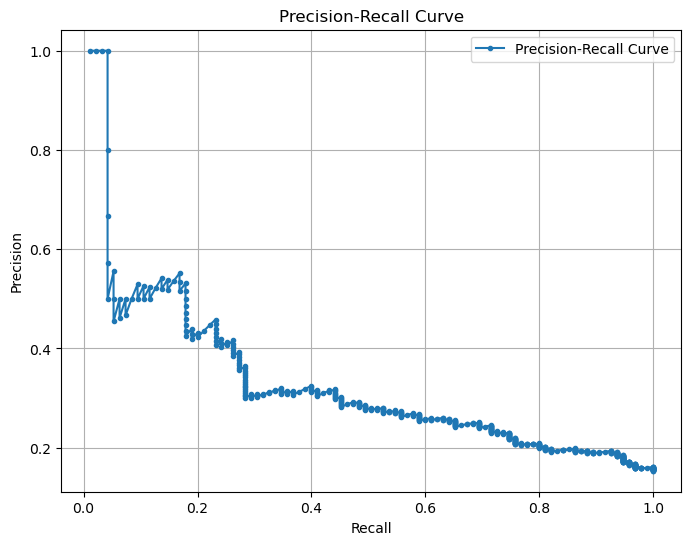

In [2276]:
plt.figure(figsize=(8, 6))
plt.plot(recalls[:-1], precisions[:-1], marker='.', label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()

If recall is more important (e.g., in medical applications where missing CHD cases is dangerous), we should choose a threshold where recall is higher, even if precision drops. Potentially, we could use threshold between 0.15 and 0.2, to fix cases when patients are indeed unhealthy for a treatment prescription.

Accuracy: 0.6521
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.65      0.76       523
           1       0.25      0.65      0.37        95

    accuracy                           0.65       618
   macro avg       0.58      0.65      0.56       618
weighted avg       0.81      0.65      0.70       618

Confusion Matrix:
 [[341 182]
 [ 33  62]]


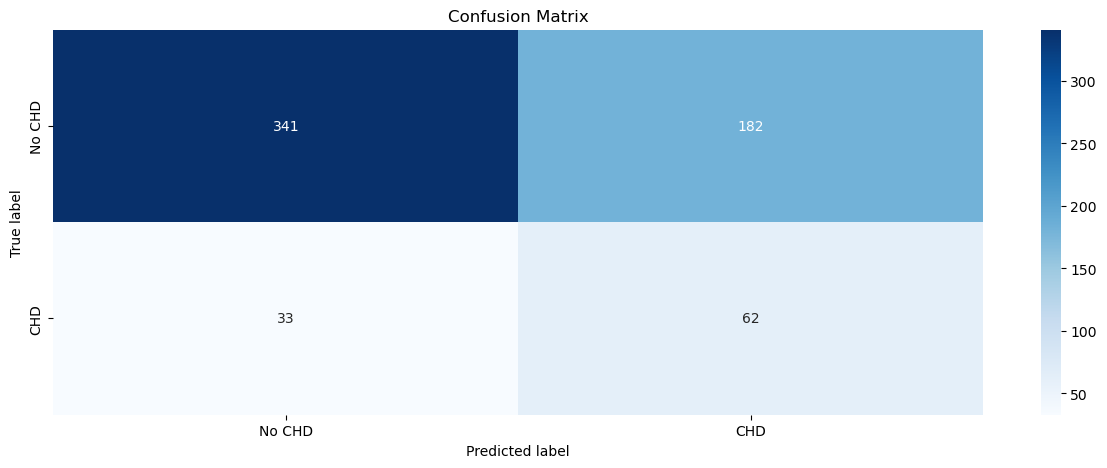

Predicted class distribution: (array([0, 1]), array([374, 244], dtype=int64))


In [2279]:
y_pred = (y_probs >= 0.15).astype(int)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))  # Avoid undefined metrics

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No CHD', 'CHD'], yticklabels=['No CHD', 'CHD'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

# Check class distribution in predictions
y_pred_counts = np.unique(y_pred, return_counts=True)
print("Predicted class distribution:", y_pred_counts)

What we can see from it?

182 False Positives (Type 1 Error): Many cases are falsely predicted as CHD, reducing precision.
33 False Negatives (Type 2 Error): Some real CHD cases are missed, but recall (0.65) is still reasonable.

Compared to previous results (precision for CHD = 0.32, recall = 0.44, F1-score = 0.37), the recall for CHD has increased from 0.44 to 0.65, meaning the model captures more actual CHD cases.
However, precision for CHD dropped from 0.32 to 0.25, meaning more false positives.

## Possible Improvements
Handle Class Imbalance
The model is biased toward predicting "No CHD" because of the imbalance in the dataset. To fix this, use oversampling (SMOTE) to generate synthetic samples for the minority class or undersampling to reduce the majority class size. Another approach is to assign higher class weights using LogisticRegression(class_weight='balanced'), which will penalize misclassifications of CHD cases more heavily.

Feature Engineering
Adding more relevant features could help the model make better predictions. Exploring non-linear relationships by adding polynomial features or interaction terms could improve performance. Feature selection techniques like Recursive Feature Elimination (RFE) may help identify the most important predictors.

Adjust Decision Threshold
The current threshold of 0.22783 was selected based on the F1-score, but it may not be the best for medical use. Since missing CHD cases is more dangerous than false alarms, optimizing for higher recall might be a better strategy. The Precision-Recall curve can help find a better threshold that improves CHD detection.

Different Models
Logistic Regression may not be the best model for this task. More complex models like Random Forest, XGBoost, or Neural Networks might perform better. Ensemble methods like Bagging or Boosting can also help improve recall while maintaining overall accuracy.